<a href="https://colab.research.google.com/github/sgcortes/2023_NAPLES/blob/main/SOL_Lect3_MLP_SENTINEL2_LAND_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
  <tr>
    <td><img src="https://unioviedo-my.sharepoint.com/:i:/g/personal/sgcortes_uniovi_es/Ebr0ybKDTBNKtoJyzmTBuRYBXY7nE-cCYaH-WDIVJxEVWA?&download=1" width="211" height="69" alt="Uniovi & EP Mieres logos" title="Uniovi & EP Mieres logos" /></td>
    <td><font color=brown>Deep Learning<br></font>
    <font color=green>Universidad de Oviedo. <br>ML & DL Naples 2023</font> <br><br>sgcortes@uniovi.es</td>
  </tr>
</table>

In [1]:
# ESTA CELDA SOLO SE DEBE EJECUTAR UNA VEZ PARA DESCARGAR LOS DATOS. SI SE PIERDE LA CONEXIÓN DEL LIBRO PRO INACTIVIDAD SE DEBERÁ EJECUTAR DE NUEVO.
#!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
#!pip install tensorflow==2.2.0
# Las dos líneas anteriores no serán necesarias en general ya que TensorFlow está instalado por defecto en Google Colab y el enlace siguiente a uniovi shaorepoint funciona para descargar los datos. 
!wget -O EuroSAT.zip 'https://unioviedo-my.sharepoint.com/:u:/g/personal/sgcortes_uniovi_es/ESV-U5iHa_FIu2WVnU_Ysu0BLFb1BX1hzvzTFbivXLj1ZA?e=GOfJP9&download=1'
!unzip -qq EuroSAT.zip
%cd 2750

#NOTE: RUN THIS CELL ONLY ONCE. After first execution the dataset should be locally in the Google sesion content folder. Then comment the 3 commands of the cell.

--2023-05-23 08:13:30--  https://unioviedo-my.sharepoint.com/:u:/g/personal/sgcortes_uniovi_es/ESV-U5iHa_FIu2WVnU_Ysu0BLFb1BX1hzvzTFbivXLj1ZA?e=GOfJP9&download=1
Resolving unioviedo-my.sharepoint.com (unioviedo-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2603:1061:13f0:301a::, ...
Connecting to unioviedo-my.sharepoint.com (unioviedo-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/sgcortes_uniovi_es/Documents/2020_VISION/EuroSAT.zip?ga=1 [following]
--2023-05-23 08:13:31--  https://unioviedo-my.sharepoint.com/personal/sgcortes_uniovi_es/Documents/2020_VISION/EuroSAT.zip?ga=1
Reusing existing connection to unioviedo-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/x-zip-compressed]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  24.9MB/s    in 5.3s    

2023-05-23 08:13:36 (17.0 MB/s) - ‘EuroSAT.zip’ saved [94280567/9428

## Scene Multiclass Classification Example with MLP (Multilayer Perceptron)
In this example the dataset from the file EUROSAT.zip will be clssified using a MLP. Images are RGB 64x64 pixels size. These tiles are stored in folder which names are the real class name they belong to.  

The original dataset can be dowloaded also from: http://madm.dfki.de/downloads
There are about 27.000 subimáges from Sentinel 2 imagery in this dataset.

**Please try to complete the empty code to finish with all the steps of the classification.**

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix

ruta_datos = '/content/2750/'

The sub-images are organised in folders whose names are the names of the data classes, which are 10 types of land cover.

In [3]:
clases = os.listdir(ruta_datos)
print(clases)

['HerbaceousVegetation', 'Forest', 'Pasture', 'AnnualCrop', 'SeaLake', 'Industrial', 'PermanentCrop', 'River', 'Highway', 'Residential']


## Loading data.
We will create a dictionary of classes with the equivalence of the class number and its name, two matrices, one of input data with all the image matrices and another one (a vector actually) with the digit indicating the class.

In [4]:
dic_clases = {}
datos_entrada = []
datos_salida = []
i = 0

for i, clase in enumerate(clases):
    if os.path.isdir(ruta_datos+clase):
        for file in os.listdir(ruta_datos+clase):
            im = Image.open(os.path.join(ruta_datos, clase,file))
            im_array = np.array(im)
            datos_entrada.append(im_array)
            datos_salida.append(i)
        dic_clases[i] = clase
        
        
datos_entrada = np.array(datos_entrada)
datos_salida = np.array(datos_salida)

In [5]:
print('Input data shape: ', datos_entrada.shape)
print('Data Type: ', datos_entrada.dtype)
print('Class label index: (First 5 elements) \n',datos_salida[0:5])
print(dic_clases)

Input data shape:  (27000, 64, 64, 3)
Data Type:  uint8
Class label index: (First 5 elements) 
 [0 0 0 0 0]
{0: 'HerbaceousVegetation', 1: 'Forest', 2: 'Pasture', 3: 'AnnualCrop', 4: 'SeaLake', 5: 'Industrial', 6: 'PermanentCrop', 7: 'River', 8: 'Highway', 9: 'Residential'}


Display of one land cover image from of each class:

(27000,)
[0, 3000, 6000, 8000, 11000, 14000, 16500, 19000, 21500, 24000]


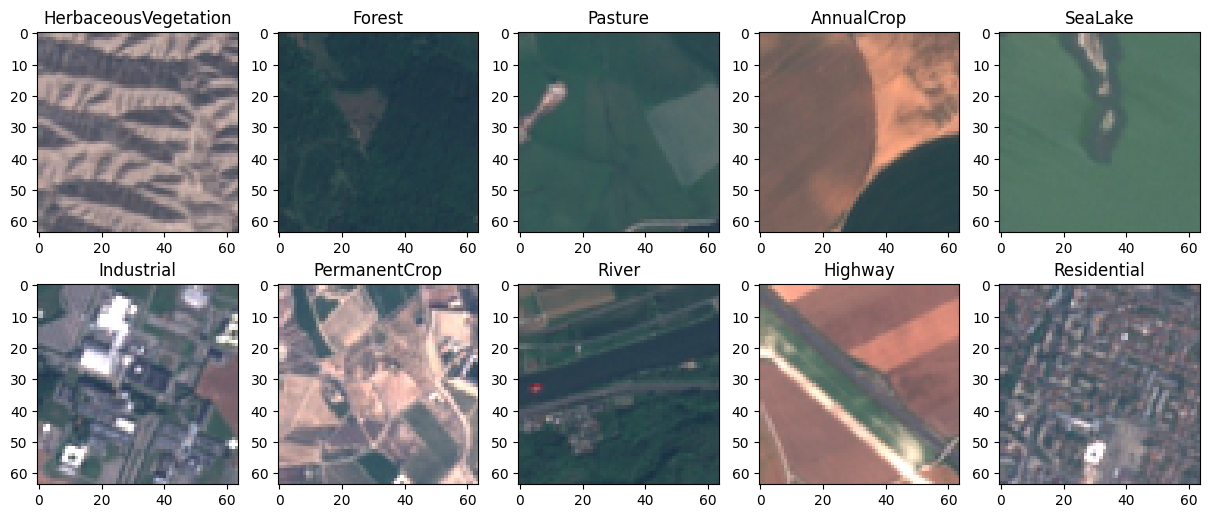

In [6]:
print(datos_salida.shape)
ind_ejemplos = [np.where(datos_salida == i)[0][0] for i in range(10)]
print(ind_ejemplos)
fig, axs = plt.subplots(2,5, figsize=(15,6))
axs = axs.ravel()
for i,ax in enumerate(axs):
    axs[i].imshow(datos_entrada[ind_ejemplos[i]])
    axs[i].set_title(clases[i])

## Training and validation spliting
We split the data into a training set (80%) and the rest of the test set:

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, clases_train, clases_test =train_test_split(datos_entrada,
                                                           datos_salida,
                                                           train_size=0.8,
                                                           shuffle=True)

## Image data normalization

In [8]:
# Normalización de imágenes
x_train = x_train/255
x_test =x_test/255

## Data resizing
Tensor size for MLP must be one row per sample and as many columnas as pixel there exist in the subimage.

In [9]:
# Comprobamos el tamaño del conjunto de datos
print(x_train.shape)
print(x_test.shape)

(21600, 64, 64, 3)
(5400, 64, 64, 3)


In [10]:
x_train = x_train.reshape(21600,12288) # 64*64*3=12288
x_test = x_test.reshape(5400,12288)

## Class label codification with One-hot encoding

In [11]:
#Convertimos las clases indicadas al formato one-hot:
y_train = keras.utils.to_categorical(clases_train)
y_test = keras.utils.to_categorical(clases_test)
print(y_test.shape)
print(x_test.shape)

(5400, 10)
(5400, 12288)


### Model design

In [12]:
mlp1 = Sequential()
mlp1.add(Dense(2048,activation='relu',input_shape=(12288,)))
mlp1.add(Dense(1024, activation='relu'))#
mlp1.add(Dense(512, activation='relu'))#
mlp1.add(Dense(256, activation='relu'))#
mlp1.add(Dense(10, activation='softmax'))

The output layer has to be softmax as it is a "multi-class" classification problem and must have 10 neurons as there are 10 classes to classify. The input size must also be 12288 which is the product of 64 x 64 x 3.


### Model compilation

In [13]:
mlp1.compile(optimizer='adam',#'adam'
            loss='categorical_crossentropy',
            metrics=['accuracy'])

## Model training

In [14]:
hist = mlp1.fit(x_train, y_train,
               epochs =20,#25
               batch_size =50,#128
               validation_data=(x_test, y_test))

Epoch 1/20
432/432 [==============================] - 11s 10ms/step - loss: 1.9778 - accuracy: 0.2990 - val_loss: 1.6431 - val_accuracy: 0.3698
Epoch 2/20
432/432 [==============================] - 4s 9ms/step - loss: 1.5707 - accuracy: 0.4126 - val_loss: 1.4873 - val_accuracy: 0.4391
Epoch 3/20
432/432 [==============================] - 4s 9ms/step - loss: 1.4838 - accuracy: 0.4488 - val_loss: 1.5913 - val_accuracy: 0.4091
Epoch 4/20
432/432 [==============================] - 4s 9ms/step - loss: 1.4210 - accuracy: 0.4730 - val_loss: 1.4383 - val_accuracy: 0.4665
Epoch 5/20
432/432 [==============================] - 4s 9ms/step - loss: 1.3807 - accuracy: 0.4914 - val_loss: 1.3765 - val_accuracy: 0.4987
Epoch 6/20
432/432 [==============================] - 4s 10ms/step - loss: 1.3169 - accuracy: 0.5200 - val_loss: 1.3770 - val_accuracy: 0.5013
Epoch 7/20
432/432 [==============================] - 4s 9ms/step - loss: 1.2622 - accuracy: 0.5456 - val_loss: 1.2604 - val_accuracy: 0.5444
Epo

### Model Valuation:
Loss and accuracy graphics through the epochs.

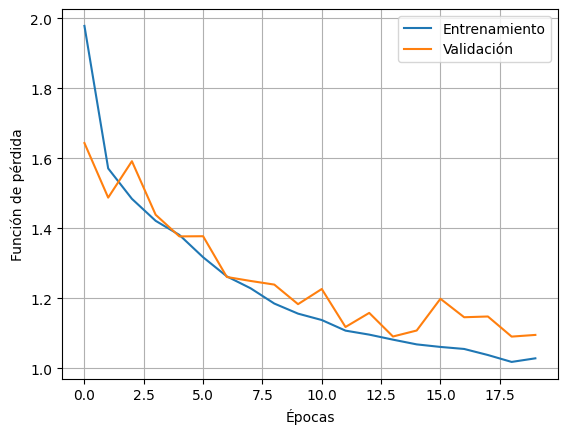

In [15]:
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.xlabel('Épocas')
plt.ylabel('Loss Function')
plt.legend()
plt.grid()

### Model evaluation: Evolution of accuracy over epochs for the training and validation set

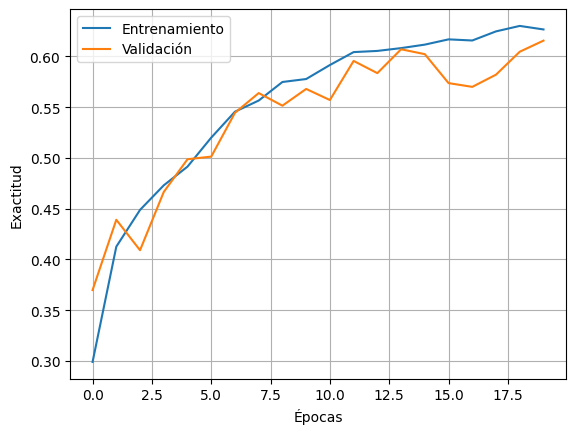

In [16]:
plt.plot(hist.history['accuracy'], label='Training')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

### Predictions

In [17]:
y_prob_train = mlp1.predict(x_train)
y_prob_test = mlp1.predict(x_test)

y_pred_train = np.argmax(y_prob_train, axis=1)
y_pred_test = np.argmax(y_prob_test, axis=1)
print(y_pred_train[0:5])

169/169 [==============================] - 1s 3ms/step
[2 5 9 2 1]


### Metrics: precision, recall, accuracy and F1

In [18]:
acc_train = accuracy_score(clases_train, y_pred_train)
acc_test = accuracy_score(clases_test, y_pred_test)

prec_train = precision_score(clases_train, y_pred_train, average='macro')
prec_test = precision_score(clases_test, y_pred_test, average='macro')

rec_train = recall_score(clases_train, y_pred_train, average='macro')
rec_test = recall_score(clases_test, y_pred_test, average='macro')

f1_train = f1_score(clases_train, y_pred_train, average='macro')
f1_test = f1_score(clases_test, y_pred_test, average='macro')

print('Training Accuracy: ', format(100*acc_train, '.2f'),'%')
print('Validation Accuracy: ', format(100*acc_test, '.2f'),'\n')


print('Training Precision: ', format(100*prec_train, '.2f'),'%')
print('Validation Precision: ', format(100*prec_test, '.2f'),'\n')

print('Training Recall: ', format(100*rec_train, '.2f'),'%')
print('Validation Recall: ', format(100*rec_test, '.2f'),'\n')

print('Training F1: ', format(f1_train, '.3f'))
print('Validation F1: ', format(f1_test, '.3f'),'\n')

Exactitud entenamiento:  64.35 %
Exactitud validación 61.56 

Precision entenamiento:  65.38 %
Precision validación 62.93 

Exhaustividad entenamiento:  63.71 %
Exhaustividad validación 61.46 

Valor F entenamiento:  0.637
Valor F validación 0.615 



### Confusion matrix

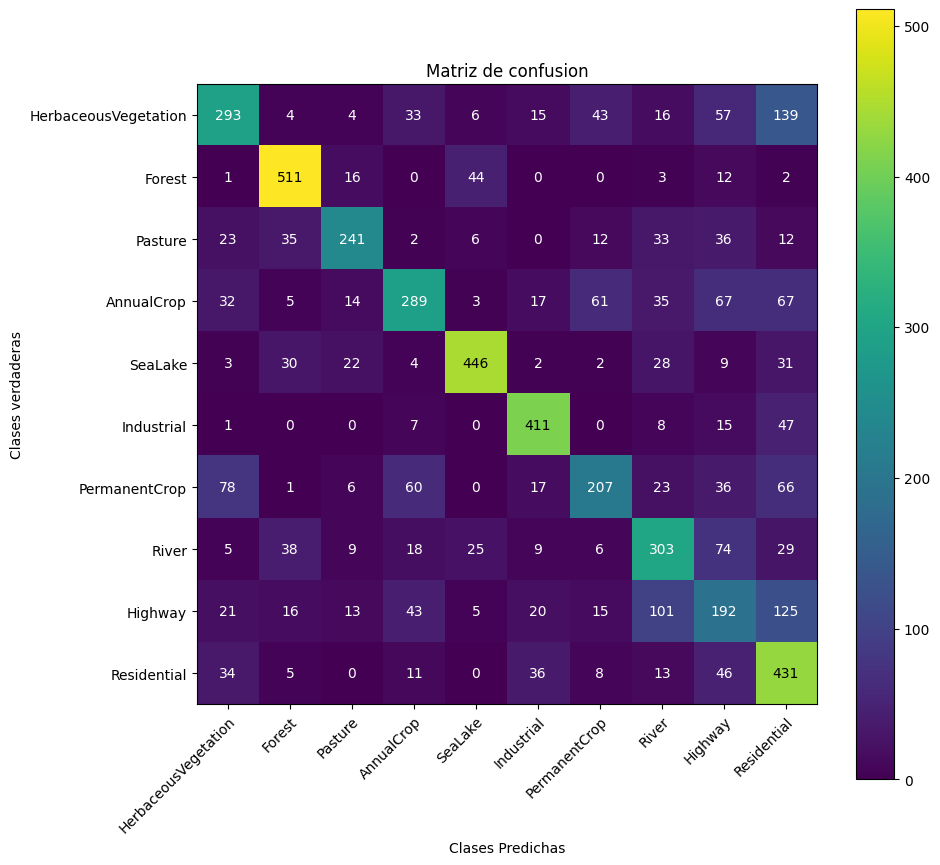

In [19]:
# Matriz de confusion
cm = confusion_matrix(clases_test, y_pred_test)

# Gráficas matriz confusion
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# Añade títulos y etiquetas al gráfico
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=clases, yticklabels=clases,
       title='Confusion matrix',
       ylabel='Predicted Classes',
       xlabel='True Classes')

# Rota los nombres de las etiquetas en el eje x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i, cm[i,j],
               ha="center", va="center",
               color="white" if cm[i,j] <350 else "black")
plt.show()